✅ Fetched 50 cryptocurrencies
Epoch 0, Loss: 0.007305
Epoch 20, Loss: 0.000048
Epoch 40, Loss: 0.000008
Epoch 60, Loss: 0.000001
Epoch 80, Loss: 0.000000
Epoch 100, Loss: 0.000000
Epoch 120, Loss: 0.000000
Epoch 140, Loss: 0.000000
Epoch 160, Loss: 0.000000
Epoch 180, Loss: 0.000000


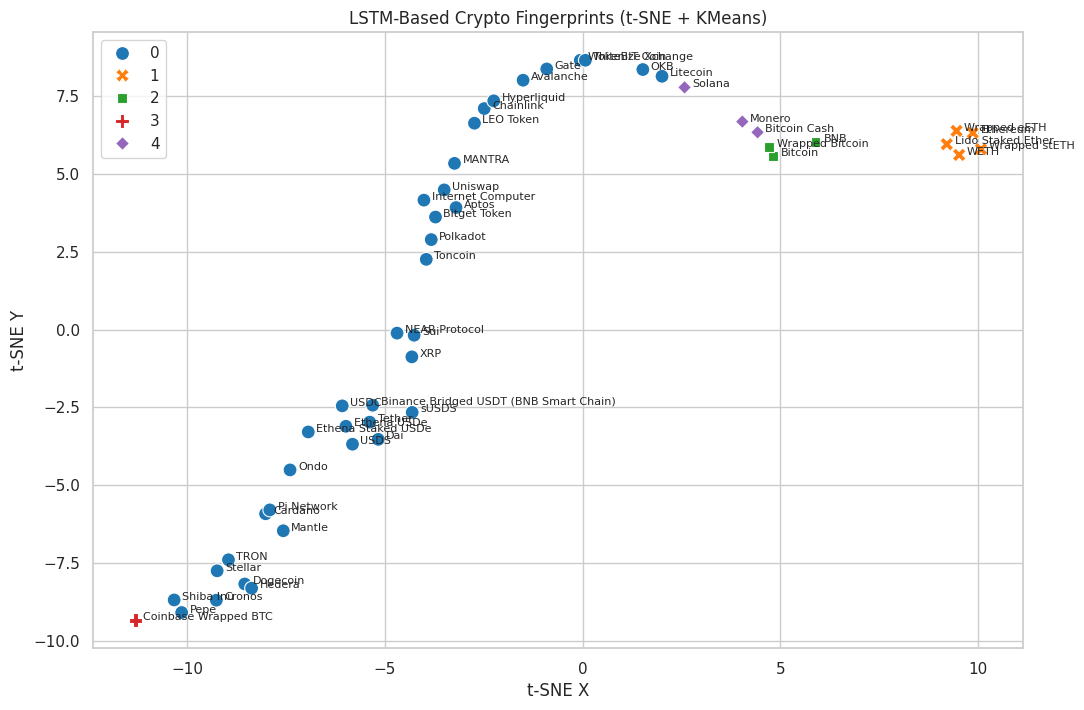

In [ ]:

!pip install -q torch seaborn

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
sns.set(style="whitegrid")

def fetch_crypto_data(vs_currency='usd', top_n=50):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        'vs_currency': vs_currency,
        'order': 'market_cap_desc',
        'per_page': top_n,
        'page': 1,
        'sparkline': 'true'
    }
    response = requests.get(url, params=params)
    data = response.json()

    names, prices = [], []
    for coin in data:
        names.append(coin['name'])
        prices.append(coin['sparkline_in_7d']['price'])

    return np.array(prices), names

prices, names = fetch_crypto_data()
print(f"✅ Fetched {len(names)} cryptocurrencies")

scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

X = torch.tensor(prices_scaled, dtype=torch.float32).unsqueeze(-1)

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, latent_dim=16):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        latent = self.linear(hn.squeeze(0))
        return latent

model = LSTMEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

target_latents = torch.zeros(X.shape[0], 16)

epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    latent = model(X)
    loss = loss_fn(latent, target_latents)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

with torch.no_grad():
    crypto_fingerprints = model(X).numpy()

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
tsne_result = tsne.fit_transform(crypto_fingerprints)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(crypto_fingerprints)

df_plot = pd.DataFrame({
    "x": tsne_result[:, 0],
    "y": tsne_result[:, 1],
    "Coin": names,
    "Cluster": clusters
})

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_plot, x="x", y="y", hue="Cluster", style="Cluster", s=100, palette="tab10")
for i, row in df_plot.iterrows():
    plt.text(row["x"] + 0.2, row["y"], row["Coin"], fontsize=8)
plt.title("LSTM-Based Crypto Fingerprints (t-SNE + KMeans)")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.legend()
plt.show()
